# Development Phase

## Training of models 

!nvidia-smi commmand shows what GPU is being used and the specifications of the GPU.

In [1]:
!nvidia-smi

Fri Mar  8 19:09:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.10              Driver Version: 551.61         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3080 Ti     On  |   00000000:2D:00.0  On |                  N/A |
|  0%   52C    P0            107W /  350W |    1651MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Importing all necessary libraries and packages that will be used later

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import sklearn.metrics as metrics

import matplotlib.pyplot as plt

2024-03-08 19:09:02.607409: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 19:09:02.607453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 19:09:02.607982: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 19:09:02.611982: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Navigation of file folder to mounted volume in docker container

In [3]:
%cd ..
%cd Documents/DATASETS/archive/DATASETS/archive
%ls

/
/Documents/DATASETS/archive/DATASETS/archive
Train/  age_detection.csv*  test/  train.csv*


/usr/local/lib/python3.11/dist-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [4]:
pip install pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd

import os
import glob

from pathlib import Path
import pandas as pd

Loading of files and files for the first dataset

In [6]:
train_path = Path('Train/dataset_2')  # Convert the string path to a Path object

files = []  # store file paths
labels = []  # store labels (age groups)

# Iterate over each directory in train_path
for age_group_dir in train_path.iterdir():
    if age_group_dir.is_dir():  # Make sure it's a directory
        age_group = age_group_dir.name  # check if folder name is the age group

        # Iterate over each image file in the current age_group_dir
        for image_path in age_group_dir.iterdir():
            if image_path.is_file():  # Make sure it's a file
                files.append(image_path)  # Convert Path object to string if necessary
                labels.append(age_group)

# Create a DataFrame
train_df = pd.DataFrame({
    'file': files,
    'label': labels
})
train_df.dtypes

file     object
label    object
dtype: object

In [7]:
# Define the path to the test data directory
test_path = Path('test')

files = []  # List to store file paths
labels = []  # List to store labels (age groups)

# Iterate over each directory in test_path
for age_group_dir in test_path.iterdir():
    if age_group_dir.is_dir():  # Make sure it's a directory
        age_group = age_group_dir.name  # The folder name is the age group

        # Iterate over each image file in the current age_group_dir
        for image_path in age_group_dir.iterdir():
            if image_path.is_file():  # Make sure it's a file
                files.append(str(image_path))  # Convert Path object to string if necessary
                labels.append(age_group)

# Create a DataFrame
test_df = pd.DataFrame({
    'file': files,
    'label': labels
})


Function created to categorise the age groups in young middle and old since the dataset has a slightly different format

In [8]:
def categorise_age(age_group):
  if age_group in ['18-20', '21-30']:
    return 'YOUNG'
  elif age_group in ['31-40', '41-50']:
    return 'MIDDLE'
  elif age_group == '51-60':
    return 'OLD'


In [9]:
train_df.shape
train_df.head()
print(train_df.dtypes)

file     object
label    object
dtype: object


In [10]:
train_df.head()
train_df['label'] = train_df['label'].apply(categorise_age)
print(train_df)

                             file  label
0     Train/dataset_2/18-20/0.jpg  YOUNG
1     Train/dataset_2/18-20/1.jpg  YOUNG
2    Train/dataset_2/18-20/10.jpg  YOUNG
3    Train/dataset_2/18-20/11.jpg  YOUNG
4    Train/dataset_2/18-20/12.jpg  YOUNG
..                            ...    ...
120   Train/dataset_2/51-60/5.jpg    OLD
121   Train/dataset_2/51-60/6.jpg    OLD
122   Train/dataset_2/51-60/7.jpg    OLD
123   Train/dataset_2/51-60/8.jpg    OLD
124   Train/dataset_2/51-60/9.jpg    OLD

[125 rows x 2 columns]


Replacing the labels of the original dataset from 'YOUNG', 'MIDDLE' and 'OLD' to 0, 1 and 2 respectively. This step helps to facilitate the process of training the model later on.

In [11]:
train_df['label'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2])

/tmp/ipykernel_35079/43070346.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df['label'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2])


0      0
1      0
2      0
3      0
4      0
      ..
120    2
121    2
122    2
123    2
124    2
Name: label, Length: 125, dtype: int64

In [12]:
train_df['file'][0]

PosixPath('Train/dataset_2/18-20/0.jpg')

Combination of both datasets into one bigger dataset

In [13]:
data_1 = pd.read_csv('train.csv')
data_1.head()


,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE


In [14]:
data_2 = pd.read_csv('age_detection.csv')
data_2.head()

,file,age,split
0,train/18-20/0.jpg,18-20,train
1,train/18-20/1.jpg,18-20,train
2,train/18-20/2.jpg,18-20,train
3,train/18-20/3.jpg,18-20,train
4,train/18-20/4.jpg,18-20,train


In [15]:
data_2['Class'] = data_2['age'].apply(categorise_age)
data_2.rename({'file':'ID'}, axis=1, inplace=True)
print(data_2)

                    ID    age  split  Class
0    train/18-20/0.jpg  18-20  train  YOUNG
1    train/18-20/1.jpg  18-20  train  YOUNG
2    train/18-20/2.jpg  18-20  train  YOUNG
3    train/18-20/3.jpg  18-20  train  YOUNG
4    train/18-20/4.jpg  18-20  train  YOUNG
..                 ...    ...    ...    ...
145  test/51-60/25.jpg  51-60   test    OLD
146  test/51-60/26.jpg  51-60   test    OLD
147  test/51-60/27.jpg  51-60   test    OLD
148  test/51-60/28.jpg  51-60   test    OLD
149  test/51-60/29.jpg  51-60   test    OLD

[150 rows x 4 columns]


In [16]:
combined_frames = [data_1, data_2]
combined_data = pd.concat(combined_frames)
print(combined_data)

                    ID   Class    age split
0              377.jpg  MIDDLE    NaN   NaN
1            17814.jpg   YOUNG    NaN   NaN
2            21283.jpg  MIDDLE    NaN   NaN
3            16496.jpg   YOUNG    NaN   NaN
4             4487.jpg  MIDDLE    NaN   NaN
..                 ...     ...    ...   ...
145  test/51-60/25.jpg     OLD  51-60  test
146  test/51-60/26.jpg     OLD  51-60  test
147  test/51-60/27.jpg     OLD  51-60  test
148  test/51-60/28.jpg     OLD  51-60  test
149  test/51-60/29.jpg     OLD  51-60  test

[20056 rows x 4 columns]


Calculation of naive baseline. 

The naive baseline in this case is used under the assumption of the model making the majority class prediction everytime. Therefore, the naive baseline is calculated to be 54.1%

In [17]:
counts = combined_data.groupby(['Class']).size()

counts

Class
MIDDLE    10864
OLD        2426
YOUNG      6766
dtype: int64

In [18]:
total_instances = counts.sum()
max_count = counts.max()

naive_baseline = max_count/total_instances
print("Naive Baseline Accuracy: ", naive_baseline)

Naive Baseline Accuracy:  0.5416832867969685


In [19]:
combined_data['Class'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2], inplace=True)
combined_data.head(10)

/tmp/ipykernel_35079/2929006080.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_data['Class'].replace(['YOUNG', 'MIDDLE', 'OLD'], [0, 1, 2], inplace=True)
/tmp/ipykernel_35079/2929006080.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_data['Class'].replace(['YOUNG', 'MIDDLE

,ID,Class,age,split
0,377.jpg,1,NaN,NaN
1,17814.jpg,0,NaN,NaN
2,21283.jpg,1,NaN,NaN
3,16496.jpg,0,NaN,NaN
4,4487.jpg,1,NaN,NaN
5,6283.jpg,1,NaN,NaN
6,23495.jpg,0,NaN,NaN
7,7100.jpg,0,NaN,NaN
8,6028.jpg,0,NaN,NaN
9,22617.jpg,2,NaN,NaN


In [20]:
combined_data = combined_data.drop(columns=['age', 'split'], axis=1)
combined_data.head()

,ID,Class
0,377.jpg,1
1,17814.jpg,0
2,21283.jpg,1
3,16496.jpg,0
4,4487.jpg,1


In [21]:
# pd.set_option("display.max_rows", None)
# print(combined_data)

Function created to load the images for the second dataset

In [22]:
def load_data(image_path, label):
    # Wrap readImages in tf.py_function to allow it to operate on tensors.
    image = tf.py_function(readImages, [image_path], Tout=tf.float32)

    # Ensure the image has the shape expected by your model.
    image.set_shape((512, 512, 3))

    return image, label

# Updated readImages function signature to work with tf.py_function
def readImages(path, ch=3, resize=(512, 512)):
    path = path.numpy()  # Convert the tensor to a numpy array to extract the string value
    if not isinstance(path, str):
        path = path.decode('utf-8')  # Decode the numpy bytes to a string
    kp = tf.io.read_file(path)
    kp = tf.image.decode_jpeg(kp, channels=ch)
    kp = tf.image.convert_image_dtype(kp, dtype=tf.float32)
    kp = tf.image.resize(kp, resize)
    return kp

In [23]:
# Initializing image paths variables.
image_paths = glob.glob('Train/*.jpg')
image_paths = image_paths[0:500]
print(len(image_paths))
print(type(image_path))

500
<class 'pathlib.PosixPath'>


In [24]:
# Initialize label values
labels = []
for i in image_paths:
    _,tail = os.path.split(i)
    label = combined_data.loc[combined_data['ID'] == tail]['Class'].values[0]
    labels.append(label)
print(len(labels))
print(labels)

500
[1, 2, 1, 1, 0, 1, 0, 0, 0, 2, 2, 0, 1, 1, 1, 2, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 2, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 1, 1, 0, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 1, 1, 2, 1, 0, 1, 0, 2, 2, 0, 0, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 1, 1, 2, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 2, 1, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 2, 0, 0, 2, 2, 0, 0, 0, 1, 0, 2, 1, 1, 0, 2, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 2, 0, 1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 1, 0, 1, 0, 1, 2, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 1, 1, 0, 0, 0, 2, 1, 2, 1, 1, 1, 1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 0, 1, 1, 0, 0, 1, 1, 2, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 2, 0, 2,

In [25]:
# train_1_df = pd.DataFrame({'file' : image_paths, 'label' : labels})
# train_1_df.head()

In [26]:
# combined_df = pd.concat([train_df, train_1_df], axis=0).reset_index(drop=True)

In [27]:
# combined_df.head()

Creation of train, test and validation sets

In [28]:
# Create Train, Test, and Validation datasets
train_size = int(0.8*(len(image_paths)))
test_size = 20

train_set = tf.data.Dataset.from_tensor_slices((image_paths[:train_size], labels[:train_size]))
test_set = tf.data.Dataset.from_tensor_slices((image_paths[train_size:train_size + test_size], labels[train_size :train_size + test_size]))
vali_set = tf.data.Dataset.from_tensor_slices((image_paths[train_size + test_size:], labels[train_size + test_size:]))

2024-03-08 19:09:05.890853: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 19:09:05.894658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 19:09:05.894683: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 19:09:05.895577: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:2d:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-08 19:09:05.895606: I external/local_xla/xla/stream_executor

In [29]:
print(f"Total IDs: {len(combined_data['ID'])}")
print(f"Total Image Paths: {len(image_paths)}")
print(f"Total Labels: {len(labels)}")

Total IDs: 20056
Total Image Paths: 500
Total Labels: 500


In [30]:
print(train_size)

400


In [31]:
print("Train set size:", train_set.cardinality().numpy())
print("Test set size:", test_set.cardinality().numpy())
print("Validation set size:", vali_set.cardinality().numpy())

Train set size: 400
Test set size: 20
Validation set size: 80


Data augmentation done on the train, test and validation sets

In [32]:
AUTOTUNE = tf.data.AUTOTUNE
train_set = (train_set
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)
print(train_set)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [33]:
train_set = train_set.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [34]:
AUTOTUNE = tf.data.AUTOTUNE
vali_set = (vali_set
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [35]:
# Adding data agumentation to validation images.
vali_set = vali_set.map(
    lambda image, label: (tf.image.random_flip_left_right(image), label)
).cache(
).map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
).map(
    lambda image, label: (tf.image.random_contrast(image, lower=0.4, upper=0.6), label)
).map(
    lambda image, label: (tf.image.random_brightness(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_hue(image, max_delta = 0.4), label)
).map(
    lambda image, label: (tf.image.random_saturation(image, lower=0.4, upper=0.6), label)
).shuffle(
    1000
).repeat(2)

In [36]:
test_set = (test_set
    .map(load_data, num_parallel_calls=AUTOTUNE)
    .batch(64)
    .prefetch(AUTOTUNE)
)

In [37]:
# Standardizing the test data.
test_set = test_set.map(
    lambda image, label: (tf.image.per_image_standardization(image), label)
)

### Creation of model 1

model_1 makes use of tensorflow keras MobileNetV3Large pre-trained model, adds custom layers to it and trains it further using the dataset that have been created.


In [38]:
# Pre-trained models is used here
# training from scratch requires loads of time and computational power
preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
model = tf.keras.applications.MobileNetV3Large(input_shape = (512,512,3,),include_top=False,weights='imagenet')
# model.summary()

In [39]:
#  prevents changing weights of pre-trained model.
model.trainable = False

# Custom layers to be added
inputs = tf.keras.Input(shape=(512, 512, 3))
x = preprocess_input(inputs)
x = model(x, training=True)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1000)(x)
x = BatchNormalization()(x)
x = Dense(600)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(400)(x)
x = BatchNormalization()(x)
x = Dense(100)(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(50)(x)
x = BatchNormalization()(x)
x = Dense(50)(x)
x = BatchNormalization()(x)
x = Dense(20)(x)
x = Dense(20, activation="softmax")(x)
outputs = Dense(3)(x)
model = tf.keras.Model(inputs, outputs, name='model_1')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 16, 16, 960)       2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 960)               0         
                                                                 
 dense (Dense)               (None, 1000)              961000    
                                                                 
 batch_normalization (Batch  (None, 1000)              4000

In [40]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### training the model_1 for 30 epochs

In [42]:
# Training the model
history = model.fit(train_set, epochs=30, validation_data=vali_set)

Epoch 1/30


2024-03-08 19:09:15.732228: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8906
2024-03-08 19:09:16.701868: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5f46622c10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-08 19:09:16.701892: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
2024-03-08 19:09:16.705154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709924956.753830   35169 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


14/14 [==============================] - 14s 359ms/step - loss: 1.0465 - accuracy: 0.5113 - val_loss: 0.9661 - val_accuracy: 0.5125
Epoch 2/30
14/14 [==============================] - 7s 236ms/step - loss: 0.9886 - accuracy: 0.6187 - val_loss: 0.9485 - val_accuracy: 0.5125
Epoch 3/30
14/14 [==============================] - 7s 233ms/step - loss: 0.9540 - accuracy: 0.6263 - val_loss: 0.9468 - val_accuracy: 0.5125
Epoch 4/30
14/14 [==============================] - 7s 236ms/step - loss: 0.9355 - accuracy: 0.6438 - val_loss: 0.9461 - val_accuracy: 0.5125
Epoch 5/30
14/14 [==============================] - 7s 239ms/step - loss: 0.9137 - accuracy: 0.6600 - val_loss: 0.9457 - val_accuracy: 0.5125
Epoch 6/30
14/14 [==============================] - 7s 242ms/step - loss: 0.8959 - accuracy: 0.6675 - val_loss: 1.0697 - val_accuracy: 0.5188
Epoch 7/30
14/14 [==============================] - 7s 234ms/step - loss: 0.8719 - accuracy: 0.6938 - val_loss: 0.9422 - val_accuracy: 0.5125
Epoch 8/30
14/14

Training results of model_1

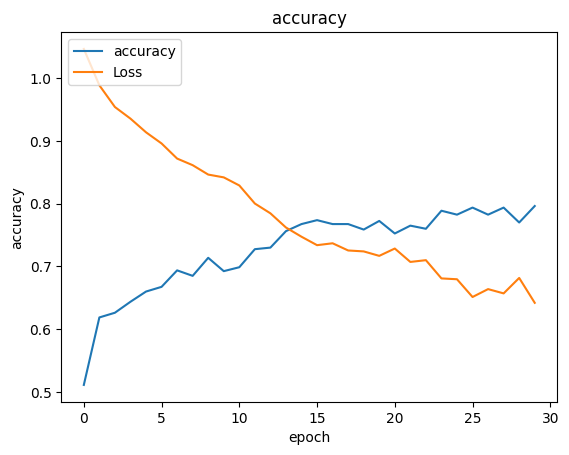

In [43]:
# Plotting the train results.
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'Loss'], loc='upper left')
plt.show()

In [44]:
# Predict probabilites of test data.
probabilities = model.predict(test_set)
# print(probabilities)
# Create classes from predictions
predictions = np.argmax(probabilities,axis=1)
actual_values = labels[train_size :train_size + test_size]
print(actual_values)
print(predictions)

1/1 [==============================] - 1s 775ms/step
[2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0]
[1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [45]:
print("balanced accuracy:   %0.3f" % metrics.balanced_accuracy_score(actual_values, predictions))
print("accuracy:   %0.3f" % metrics.accuracy_score(actual_values, predictions))

balanced accuracy:   0.381
accuracy:   0.600


The functions below are created to aid in the evaluation of the model by calculating and printing out the scores.

In [46]:
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

In [47]:
def extract_labels(test_set):
    all_labels = []
    for images, labels in test_set:
        all_labels.extend(labels.numpy())
    return np.array(all_labels)

# Making predictions with the test set
# Note: predictions is accumlated batch by batch
y_pred = []
for x, _ in test_set:
    predictions = model.predict(x)
    predicted_classes = np.argmax(predictions, axis=1)
    y_pred.extend(predicted_classes)
y_pred = np.array(y_pred)

# Extracting true labels from the test set
true_labels = extract_labels(test_set)

# Computing the confusion matrix
conf_matrix = confusion_matrix(true_labels, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Classification report for precision, recall, f1-score
print("\nClassification Report:\n", classification_report(true_labels, y_pred))

# Accuracy
accuracy = np.mean(y_pred == true_labels)
print("Accuracy: {:.2f}%".format(accuracy * 100))

1/1 [==============================] - 1s 585ms/step
Confusion Matrix:
 [[ 1  6  0]
 [ 0 11  0]
 [ 0  2  0]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.58      1.00      0.73        11
           2       0.00      0.00      0.00         2

    accuracy                           0.60        20
   macro avg       0.53      0.38      0.33        20
weighted avg       0.67      0.60      0.49        20

Accuracy: 60.00%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


This function is created to calculate as well as plot the Reciever Operating Characteristics Curve (ROC) for model_1.

1/1 [==============================] - 0s 118ms/step


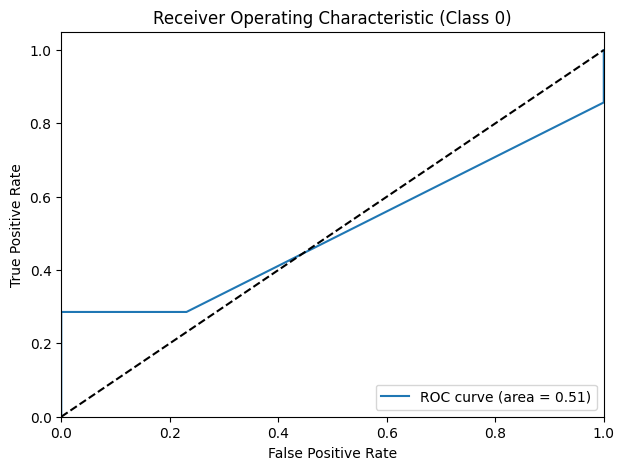

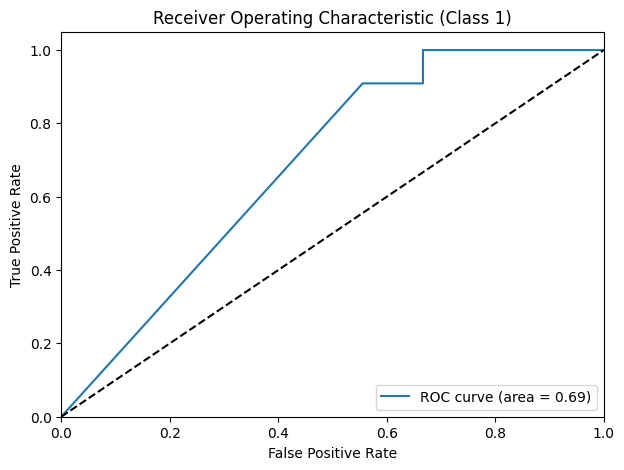

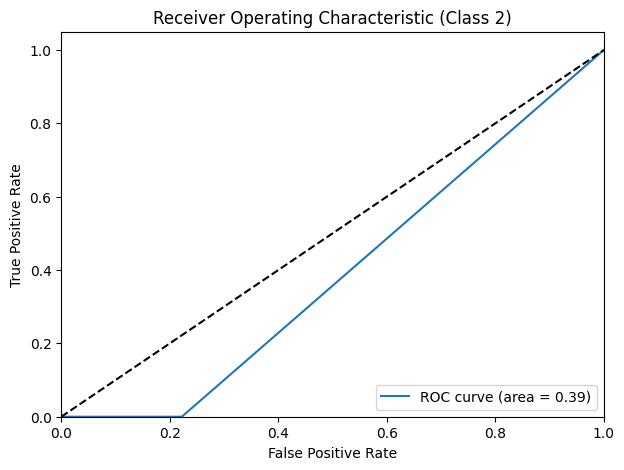

In [48]:
y_true = []
for img, label in test_set.unbatch().take(-1):  # `.take(-1)` takes the whole dataset
    y_true.append(label.numpy())

# Convert to a numpy array
y_true = np.array(y_true)

# Binarize the labels for multi-class ROC curve
n_classes = 3  # Adjust based on your dataset
y_true = label_binarize(y_true, classes=range(n_classes))

# Predict probabilities for the test set
y_pred = model.predict(test_set.map(lambda x, y: x))  # Only extract images, discard labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 5))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (Class {i})')
    plt.legend(loc="lower right")
    plt.show()


### Training of model_2

model_2 is created using the same MobileNetV3Large pre-trained model. The difference is that model_2 has different custom layers added to it. model_2 is then trained using the same dataset as model_1 for the same number of epochs.

In [49]:
# Load the pre-trained MobileNetV3Large model
base_model = tf.keras.applications.MobileNetV3Large(input_shape=(512, 512, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model for 'model_2'

# Custom layers for 'model_2'
inputs_2 = Input(shape=(512, 512, 3))
x_2 = tf.keras.applications.mobilenet_v3.preprocess_input(inputs_2)
x_2 = base_model(x_2, training=False)  # Ensure the base_model is in inference mode here

# Add custom convolutional layers for 'model_2'
x_2 = Conv2D(128, (3, 3), activation='relu')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = GlobalAveragePooling2D()(x_2)

# Simplified Dense layers with regularization for 'model_2'
x_2 = Dense(256, activation='relu')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dropout(0.5)(x_2)  # Increased dropout for regularization
x_2 = Dense(128, activation='relu')(x_2)
x_2 = BatchNormalization()(x_2)
x_2 = Dropout(0.5)(x_2)

# Final layers for 'model_2'
x_2 = Dense(20, activation='softmax')(x_2)  
outputs_2 = Dense(3, activation='softmax')(x_2)  # one for each class

# Create 'model_2'
model_2 = Model(inputs_2, outputs_2, name='model_2')


model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 16, 16, 960)       2996352   
 al)                                                             
                                                                 
 conv2d (Conv2D)             (None, 14, 14, 128)       1106048   
                                                                 
 batch_normalization_6 (Bat  (None, 14, 14, 128)       512       
 chNormalization)                                                
                                                                 
 global_average_pooling2d_1  (None, 128)               0         
  (GlobalAveragePooling2D)                                       
                                                           

In [50]:
# Compile 'model_2'
model_2.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Training model_2 for 30 epochs

In [51]:
# Training the model
history_2 = model_2.fit(train_set, epochs=30, validation_data=vali_set)

Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


14/14 [==============================] - 17s 433ms/step - loss: 1.0643 - accuracy: 0.4750 - val_loss: 1.0428 - val_accuracy: 0.5125
Epoch 2/30
14/14 [==============================] - 7s 223ms/step - loss: 1.0352 - accuracy: 0.5300 - val_loss: 1.0253 - val_accuracy: 0.5125
Epoch 3/30
14/14 [==============================] - 7s 227ms/step - loss: 1.0070 - accuracy: 0.5525 - val_loss: 1.0273 - val_accuracy: 0.5125
Epoch 4/30
14/14 [==============================] - 7s 222ms/step - loss: 0.9946 - accuracy: 0.5537 - val_loss: 1.0310 - val_accuracy: 0.5125
Epoch 5/30
14/14 [==============================] - 7s 227ms/step - loss: 0.9757 - accuracy: 0.5650 - val_loss: 1.0293 - val_accuracy: 0.5125
Epoch 6/30
14/14 [==============================] - 7s 276ms/step - loss: 0.9578 - accuracy: 0.5763 - val_loss: 1.0278 - val_accuracy: 0.5125
Epoch 7/30
14/14 [==============================] - 8s 224ms/step - loss: 0.9466 - accuracy: 0.5875 - val_loss: 1.0141 - val_accuracy: 0.5125
Epoch 8/30
14/14

In [52]:
# Predict probabilites of test data.
probabilities_2 = model_2.predict(test_set)

# Create classes from predictions
print("model 2 predictions")
predictions_2 = np.argmax(probabilities_2,axis=1)
actual_values_2 = labels[train_size :train_size + test_size]
print(actual_values_2)
print(predictions_2)

1/1 [==============================] - 1s 664ms/step
model 2 predictions
[2, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0]
[1 1 1 1 0 1 1 2 2 1 1 1 1 1 2 1 1 1 1 1]


In [53]:
print("balanced accuracy:   %0.3f" % metrics.balanced_accuracy_score(actual_values_2, predictions_2))
print("accuracy:   %0.3f" % metrics.accuracy_score(actual_values_2, predictions_2))


balanced accuracy:   0.351
accuracy:   0.550


Calculation of evaluation metrics for model_2

In [54]:
y_pred_2 = []
for x, _ in test_set:
    predictions_2 = model_2.predict(x)
    predicted_classes_2 = np.argmax(predictions_2, axis=1)
    y_pred_2.extend(predicted_classes_2)
y_pred_2 = np.array(y_pred_2)

# Extracting true labels from the test set
true_labels = extract_labels(test_set)

# Computing the confusion matrix
conf_matrix_2 = confusion_matrix(true_labels, y_pred_2)
print("Confusion Matrix for model 2:\n", conf_matrix_2)

# Classification report for precision, recall, f1-score
print("\nClassification Report for model 2:\n", classification_report(true_labels, y_pred_2))

# Accuracy
accuracy_2 = np.mean(y_pred_2 == true_labels)
print("Accuracy for model 2: {:.2f}%".format(accuracy_2 * 100))

1/1 [==============================] - 1s 545ms/step
Confusion Matrix for model 2:
 [[ 1  4  2]
 [ 0 10  1]
 [ 0  2  0]]

Classification Report for model 2:
               precision    recall  f1-score   support

           0       1.00      0.14      0.25         7
           1       0.62      0.91      0.74        11
           2       0.00      0.00      0.00         2

    accuracy                           0.55        20
   macro avg       0.54      0.35      0.33        20
weighted avg       0.69      0.55      0.49        20

Accuracy for model 2: 55.00%


Calculation and Plotting of ROC curve for model_2

1/1 [==============================] - 0s 108ms/step


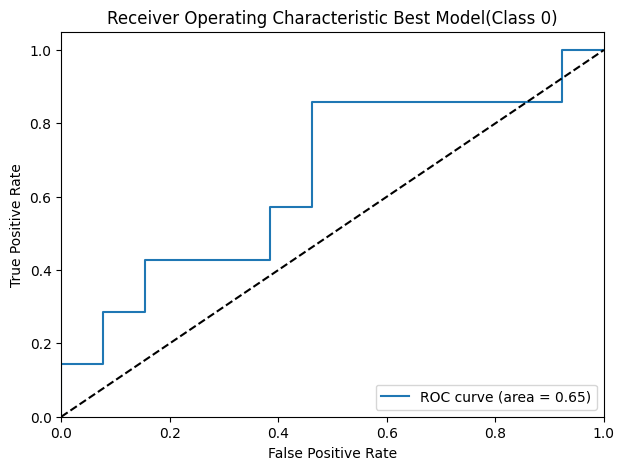

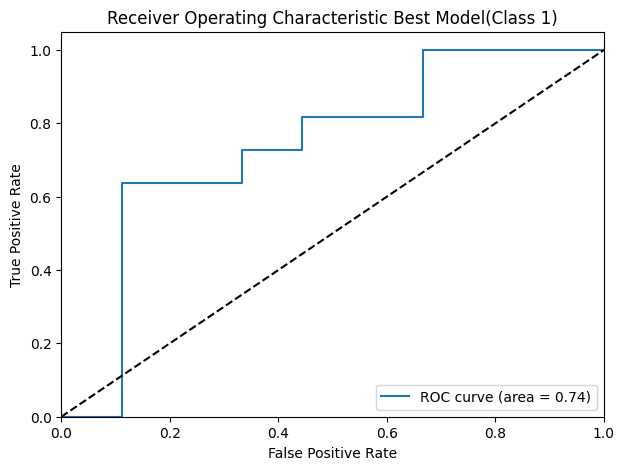

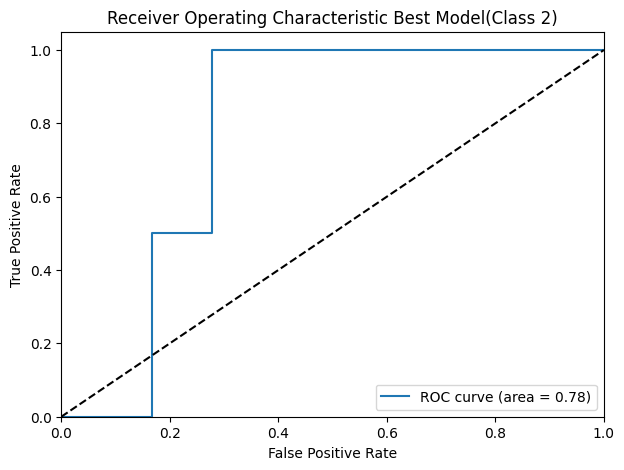

In [55]:
y_true = []
for img, label in test_set.unbatch().take(-1):  # `.take(-1)` takes the whole dataset
    y_true.append(label.numpy())

# Convert to a numpy array
y_true = np.array(y_true)

# Binarize the labels for multi-class ROC curve
n_classes = 3 
y_true = label_binarize(y_true, classes=range(n_classes))

# Predict probabilities for the test set
y_pred_2 = model_2.predict(test_set.map(lambda x, y: x))  # Only extract images, discard labels

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred_2[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot of a ROC curve for a specific class
for i in range(n_classes):
    plt.figure(figsize=(7, 5))
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic Best Model(Class {i})')
    plt.legend(loc="lower right")
    plt.show()


These code below help to save the model in new folder created. The model architecture and weights are saved separately in this case.

In [ ]:
import os

# Ensure the directory exists
directory = 'E:/MyModels'
if not os.path.exists(directory):
    os.makedirs(directory)

# Save model architecture
with open(os.path.join(directory, 'model_architecture.json'), 'w') as f:
    f.write(model.to_json())

# Save weights
model.save_weights(os.path.join(directory, 'model_weights.h5'))

In [ ]:
# Save model_2 architecture
with open(os.path.join(directory, 'model2_architecture.json'), 'w') as f:
    f.write(model_2.to_json())

# Save weights
model.save_weights(os.path.join(directory, 'model2_weights.h5'))